# Using the documentation for Forecasting with Exogenous Regressors¶

## This is an example an AR(1) with exogeneous regressors?

In [1]:
# initial setup
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn
from arch.__future__ import reindexing

seaborn.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

## Simulating data

Two $X$
variables are simulated and are assumed to follow independent AR(1) processes. The data is then assumed to follow an ARX(1) with 2 exogenous regressors and GARCH(1,1) errors.

In [2]:
from arch.univariate import ARX, GARCH, ZeroMean, arch_model

#Burn In for the simulation
burn = 250
#Setting up an ARX model which is ARX or Autoregressive (ARX) with optional exogenous regressors

x_mod = ARX(None, lags=1)
x0 = x_mod.simulate([1, 0.8, 1], nobs=1000 + burn).data
x1 = x_mod.simulate([2.5, 0.5, 1], nobs=1000 + burn).data

# Zero mean (ZeroMean) - useful if using residuals from a model estimated separately
resid_mod = ZeroMean(volatility=GARCH())
#Simulating a zero mean model i guess
resids = resid_mod.simulate([0.1, 0.1, 0.8], nobs=1000 + burn).data


phi1 = 0.7
phi0 = 3
y = 10 + resids.copy()
for i in range(1, y.shape[0]):
    y[i] = phi0 + phi1 * y[i - 1] + 2 * x0[i] - 2 * x1[i] + resids[i]

x0 = x0.iloc[-1000:]
x1 = x1.iloc[-1000:]
y = y.iloc[-1000:]
y.index = x0.index = x1.index = np.arange(1000)



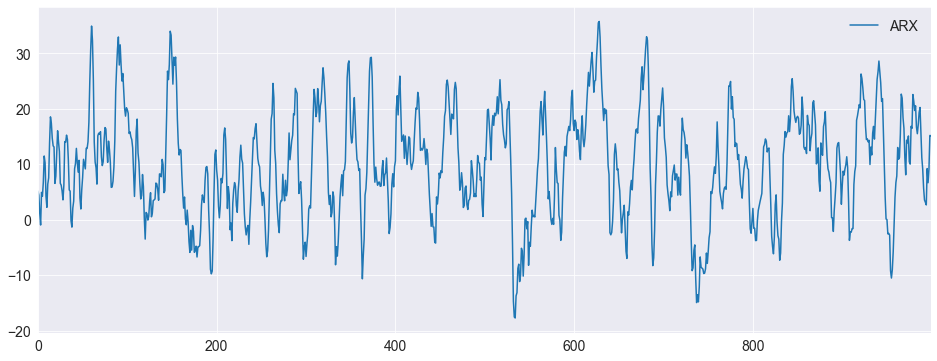

In [11]:
ax = pd.DataFrame({"ARX": y}).plot(legend=False)
ax.legend(frameon=False)
_ = ax.set_xlim(0, 999)

## Forecasting the X Values 
The forecasts of Y depend on forecasts of X0 and X1. Both of these follow simple AR(1), and so we can construct the forecasts for all time horizons. Note that the value in position [i,j] is the time-i forecast for horizon j+1.

In [14]:
x0_oos = np.empty((1000, 10))
x1_oos = np.empty((1000, 10))
for i in range(10):
    if i == 0:
        last = x0
    else:
        last = x0_oos[:, i - 1]
    x0_oos[:, i] = 1 + 0.8 * last
    if i == 0:
        last = x1
    else:
        last = x1_oos[:, i - 1]
    x1_oos[:, i] = 2.5 + 0.5 * last

x1_oos[-1]

array([5.25454531, 5.12727265, 5.06363633, 5.03181816, 5.01590908,
       5.00795454, 5.00397727, 5.00198864, 5.00099432, 5.00049716])

In [15]:
exog = pd.DataFrame({"x0": x0, "x1": x1})
mod = arch_model(y, x=exog, mean="ARX", lags=1)
res = mod.fit(disp="off")
print(res.summary())

                          AR-X - GARCH Model Results                          
Dep. Variable:                   data   R-squared:                       0.990
Mean Model:                      AR-X   Adj. R-squared:                  0.990
Vol Model:                      GARCH   Log-Likelihood:               -1373.54
Distribution:                  Normal   AIC:                           2761.09
Method:            Maximum Likelihood   BIC:                           2795.43
                                        No. Observations:                  999
Date:                Mon, Jun 27 2022   Df Residuals:                      995
Time:                        20:39:49   Df Model:                            4
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
Const          3.1026      0.153     20.268  2.440e-91 [  2.803,  3.40